In [10]:
import numpy as np
import matplotlib.pyplot as plt

P_triple = 0.51795e6
T_triple = 216.592

#Smith van Ness Abbot
Tc = 304.2 #K
Pc = 73.83e5 
w = 0.224

def Pfus(T):
    #Span Wagner CO2
    Pfus = P_triple*(1+1955.5390*((T/T_triple)-1)+2055.4593*((T/T_triple)-1)**2)
    return Pfus

def Psublim(T):
    #Span Wagner CO2
    Psublim = P_triple*np.exp((216.592/T)*(-14.740846*(1-(T/T_triple))+2.4327015*(1-(T/T_triple))**1.9-5.3061778*(1-(T/T_triple))**2.9))
    return Psublim

def Psat(T):
    Psat = 10 ** (7.5322 - (835.06)/(268.223+T-273.15)) #Dortmund database CO2
    Psat = Psat * 133.322365
    return Psat

In [11]:
T_sublim = np.linspace(100,T_triple,100)
T_fus = np.linspace(T_triple, 400,100)
T_sat = np.linspace(T_triple, Tc, 100)

In [12]:
R = 8.3144598

omega=0.086640
b = (omega*R*Tc)/Pc

def P_preos(T,V):
    return (R*T)/(V-b) - a(T)/(V*(V+b))  #PREOS escrita para pressão

def a(T):
    return ((R*R*Tc*Tc*0.427480/Pc)*(1+((0.480+1.574*w-0.176*w*w)*(1-(np.sqrt(T/Tc)))))**2)

def calcV(P,T):
    c1=P
    c2=-R*T
    c3=-b*R*T-P*b*b+a(T)
    c4=-a(T)*b
    V=np.roots([c1,c2,c3,c4])
    Vl = min(V)
    Vv = max(V)
    return (Vl,Vv)

def phiv(P,T):
    c1=P
    c2=-R*T
    c3=-b*R*T-P*b*b+a(T)
    c4=-a(T)*b
    V=np.roots([c1,c2,c3,c4])
    Vv= max(V)
    return np.exp(((P*Vv)/(R*T))-1-np.log(((P*Vv)/(R*T))-(b*P)/(R*T))- (a(T)/(b*R*T))*np.log((((P*Vv)/(R*T))+ (b*P)/(R*T))/((P*Vv)/(R*T)))), Vv

def phil(P,T):
    c1=P
    c2=-R*T
    c3=-b*R*T-P*b*b+a(T)
    c4=-a(T)*b
    V=np.roots([c1,c2,c3,c4])
    Vl= min (V)
    return np.exp(((P*Vl)/(R*T))-1-np.log(((P*Vl)/(R*T))-(b*P)/(R*T))- (a(T)/(b*R*T))*np.log((((P*Vl)/(R*T))+ (b*P)/(R*T))/((P*Vl)/(R*T)))),Vl

def H_res(T,P,V):

    Tr=T/Tc
    dev=(402374603786943180544511778531*((2253215889523281*Tr**(1/2))/2251799813685248 - 4505015703208529/2251799813685248))/(316912650057057350374175801344*Tr**(1/2))
    Z=(P*V)/(R*T);
    q=a(T)/(b*R*T);
    beta=b*P/(R*T);
    I=np.log((Z+beta)/Z);

    return Z-1+ (dev-1)*q*I

def S_res(T,P,V):
    Tr=T/Tc
    dev=(402374603786943180544511778531*((2253215889523281*Tr**(1/2))/2251799813685248 - 4505015703208529/2251799813685248))/(316912650057057350374175801344*Tr**(1/2))
    Z=(P*V)/(R*T);
    q=a(T)/(b*R*T);
    beta=b*P/(R*T);
    I=np.log((Z+beta)/Z)
   
    return np.log(Z-beta)+ dev*q*I

def P_sat(T,P_iguess):

    RES=1
    TOL=1e-9
    MAX=1000
    i=0
    P=P_iguess
    while(RES>TOL and i<MAX): 
        
        valor_phi_L, Vol_L = phil(P,T)
        valor_phi_V, Vol_V = phiv(P,T)
        
        P=P*(valor_phi_L/valor_phi_V)
        RES=abs((valor_phi_L/valor_phi_V)-1.)
        i=i+1
        
    HRES_L=H_res(T,P,Vol_L)
    HRES_V=H_res(T,P,Vol_V)
    SRES_L=S_res(T,P,Vol_L)
    SRES_V=S_res(T,P,Vol_V)  
        
    return P, Vol_L, Vol_V, HRES_L, HRES_V,SRES_L,SRES_V

def isotherm_T_lt_Tc(T,V):
    Psat, V_l, V_v,_,_,_,_ = P_sat(T,1e5)
    if (V>V_l) and (V<V_v):
        pressure = Psat
    else:
        pressure = P_preos(T,V)
    return (pressure)

def isotherm_T_solid(T,V):
    
    P_fus = Pfus(T)
    V_s = solid_volume(T,P_fus)
    V_l,_ = calcV(P_fus,T)
    Psat, V2_l, V_v,_,_,_,_ = P_sat(T,1e5)
    
    if (V<V_s):
        pressure = solid_pressure(T,V)
    elif (V>V_s) and (V<V_l):
        pressure = P_fus
    elif(V>V_l) and (V<V2_l):
        pressure = P_preos(T,V)
    elif (V>V2_l) and (V<V_v):
        pressure = Psat
    else:
        pressure = P_preos(T,V)
    return (pressure)

In [13]:
def solid_volume(T,P):
    
    a_ = (5.540 + 4.679e-6*(T**2))*1e-10
    kappa = (1.259808e-10-5.207279e-14*T+3.218216e-15*T**2)*0.25
    V = ((a_**3)/4)*6.023e23*np.exp(-kappa*(P-101325))
    
    return V

def solid_pressure(T,V):

    a_ = (5.540 + 4.679e-6*(T**2))*1e-10
    kappa = (1.259808e-10-5.207279e-14*T+3.218216e-15*T**2)*0.25
    
    P = 101325. - (1/kappa)*np.log(V/((a_**3)*6.023e23/4))
    
    return P

In [14]:
V_grid1 = np.logspace(-5,-1,400)
V_grid2 = np.logspace(-4.5,-1,400)
V_grid3 = np.logspace(-4.5,-1,400)
V_grid4 = np.logspace(-4.5,-1,400)

P_isotherm = np.zeros(400)
P_isotherm_solid = np.zeros(400)
P_isotherm_critical = np.zeros(400)
P_isotherm_supercritical=np.zeros(400)

V_l = np.zeros(len(T_sat))
V_v = np.zeros(len(T_sat))
V_s = np.zeros(len(T_fus))
V_l_fus = np.zeros(len(T_fus))
V_s_sublim = np.zeros(len(T_sublim))
V_v_sublim = np.zeros(len(T_sublim))

P_sat_eos = np.zeros(len(T_sat))
P_guess = 1e4

for i in range(len(T_sat)):
    V_s[i] = solid_volume(T_fus[i],Pfus(T_fus[i]))
    V_s_sublim[i] = solid_volume(T_sublim[i],Psublim(T_sublim[i]))
    V_l_fus[i], _ = calcV(Pfus(T_fus[i]),T_fus[i])
    
    _, V_v_sublim[i] = calcV(Psublim(T_sublim[i]),T_sublim[i])
    P_sat_eos[i], V_l[i], V_v[i], _, _, _, _ = P_sat(T_sat[i],P_guess)
    P_guess =  P_sat_eos[i]

for i in range(len(V_grid1)):
    P_isotherm[i] = isotherm_T_lt_Tc(280,V_grid2[i])
    P_isotherm_solid[i] = isotherm_T_solid(218,V_grid1[i])
    P_isotherm_critical[i] = isotherm_T_solid(Tc,V_grid3[i])
    P_isotherm_supercritical[i] = P_preos(320,V_grid4[i])



/home/medeirosfa/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
/home/medeirosfa/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
/home/medeirosfa/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:31: ComplexWarning: Casting complex values to real discards the imaginary part


/home/medeirosfa/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:533: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


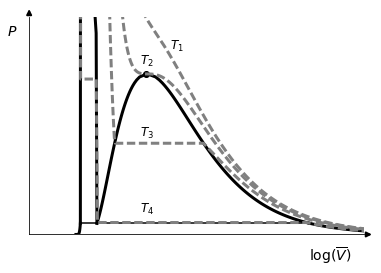

In [15]:
plt.plot(V_l,P_sat_eos,color='k',ls='-',lw=3)
plt.plot(V_v,P_sat_eos,color='k',ls='-',lw=3)

plt.plot(V_l_fus,Pfus(T_fus),color='k',ls='-',lw=3)
plt.plot(V_s,Pfus(T_fus),color='k',ls='-',lw=3)

plt.plot(V_s_sublim,Psublim(T_sublim),color='k',ls='-',lw=3)
plt.plot(V_v_sublim,Psublim(T_sublim),color='k',ls='-',lw=3)

plt.semilogx()

#plt.xlim(150,330)
plt.ylim(0,1e7)

#plt.ylim(0,Pc)
plt.xlim(1e-5,1e-2)

plt.scatter(calcV(Pc,Tc)[0],Pc,color='k')

plt.plot([V_s[0],V_v[0]],[P_triple,P_triple],color='k',ls='-')

ax = plt.gca()

xlabel = r'$\mathrm{log}(\overline{V})$'
ylabel = '$P$'

arrowprops = dict(arrowstyle='<|-', facecolor='black',lw=2)
arrow_length = 10

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_yticklabels([])
ax.set_xticklabels([])

t = ax.spines['bottom'].get_transform()
xy, xycoords = [1, 0], ('axes fraction', t)
xytext, textcoords = [arrow_length, 0], ('offset points', t)

xarrow = ax.annotate('', xy, xycoords=xycoords, xytext=xytext, 
                        textcoords=textcoords, ha='left', va='center',arrowprops=arrowprops)

t = ax.spines['left'].get_transform()
xy, xycoords = [1, 0], ('axes fraction', t)
xytext, textcoords = [arrow_length, 0], ('offset points', t)

yarrow = ax.annotate('', xy[::-1], xycoords=xycoords[::-1], 
                        xytext=xytext[::-1], textcoords=textcoords[::-1], ha='center', va='center', arrowprops=arrowprops)


plt.xlabel(xlabel,fontsize=14)
plt.ylabel(ylabel,rotation=0,fontsize=14)

ax.yaxis.set_label_coords(-0.05,0.9)
ax.xaxis.set_label_coords(0.9,-0.05)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    labelbottom='off') # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off

textbox1 = '$T_{1}$'
textbox2 = '$T_{2}$'
textbox3 = '$T_{3}$'
textbox4 = '$T_{4}$'

ax.text(0.42, 0.9, textbox1, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')

ax.text(0.33, 0.83, textbox2, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')

ax.text(0.33, 0.5, textbox3, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')

ax.text(0.33, 0.15, textbox4, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')

plt.plot(V_grid2,P_isotherm, ls='--',color='gray', lw=3)
plt.plot(V_grid1,P_isotherm_solid,color='gray', ls='--', lw=3)
plt.plot(V_grid3,P_isotherm_critical,color='gray', ls='--', lw=3)
plt.plot(V_grid4,P_isotherm_supercritical,color='gray', ls='--', lw=3)

plt.show()

/home/medeirosfa/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:533: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
/home/medeirosfa/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


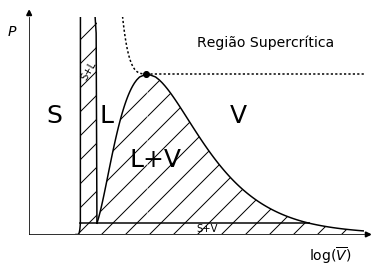

In [16]:
plt.plot(V_l,P_sat_eos,color='k',ls='-')
plt.plot(V_v,P_sat_eos,color='k',ls='-')

plt.plot(V_l_fus,Pfus(T_fus),color='k',ls='-')
plt.plot(V_s,Pfus(T_fus),color='k',ls='-')

plt.plot(V_s_sublim,Psublim(T_sublim),color='k',ls='-')
plt.plot(V_v_sublim,Psublim(T_sublim),color='k',ls='-')

plt.semilogx()

#plt.xlim(150,330)
plt.ylim(0,1e7)
#plt.ylim(0,Pc)
plt.xlim(1e-5,1e-2)

plt.scatter(calcV(Pc,Tc)[0],Pc,color='k')

plt.plot([V_s[0],V_v[0]],[P_triple,P_triple],color='k',ls='-')

ax = plt.gca()

xlabel = r'$\mathrm{log}(\overline{V})$'
ylabel = '$P$'

arrowprops = dict(arrowstyle='<|-', facecolor='black',lw=2)
arrow_length = 10

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_yticklabels([])
ax.set_xticklabels([])

t = ax.spines['bottom'].get_transform()
xy, xycoords = [1, 0], ('axes fraction', t)
xytext, textcoords = [arrow_length, 0], ('offset points', t)

xarrow = ax.annotate('', xy, xycoords=xycoords, xytext=xytext, 
                        textcoords=textcoords, ha='left', va='center',arrowprops=arrowprops)

t = ax.spines['left'].get_transform()
xy, xycoords = [1, 0], ('axes fraction', t)
xytext, textcoords = [arrow_length, 0], ('offset points', t)

yarrow = ax.annotate('', xy[::-1], xycoords=xycoords[::-1], 
                        xytext=xytext[::-1], textcoords=textcoords[::-1], ha='center', va='center', arrowprops=arrowprops)


plt.xlabel(xlabel,fontsize=14)
plt.ylabel(ylabel,rotation=0,fontsize=14)

ax.yaxis.set_label_coords(-0.05,0.9)
ax.xaxis.set_label_coords(0.9,-0.05)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    labelbottom='off') # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off

ax.fill_between(V_l, P_triple, P_sat_eos, facecolor='white', alpha=0.,
                label='1 sigma range', hatch = '/')

ax.fill_between(V_v, P_triple, P_sat_eos, facecolor='white', alpha=0.,
                label='1 sigma range', hatch = '/')

ax.fill_between(V_s_sublim,0, Psublim(T_sublim), facecolor='white', alpha=0.5,
                label='1 sigma range', hatch = '/')

ax.fill_between(V_v_sublim, 0,Psublim(T_sublim), facecolor='white', alpha=0.5,
                label='1 sigma range', hatch = '/')

ax.fill_between([V_s[0],V_v[0]], 0,P_triple, facecolor='white', alpha=0.5,
                label='1 sigma range', hatch = '/')

ax.fill_between([V_s[0],V_l_fus[0]], P_triple,1e7, facecolor='white', alpha=0.5,
                label='1 sigma range', hatch = '/')

plt.plot([calcV(Pc,Tc)[0],1e10],[Pc,Pc],ls=':',color='k')

V_grid_new = list()
P_critical_new = list()

for i in range(len(V_grid3)):
    if P_isotherm_critical[i]>Pc:
        V_grid_new.append(V_grid3[i])
        P_critical_new.append(P_isotherm_critical[i])

plt.plot(V_grid_new,P_critical_new,color='k', ls=':')

textbox1 = 'V'
textbox2 = 'L'
textbox3 = 'S'
textbox4 = 'L+V'
textbox5 = 'S+V'
textbox6 = 'S+L'
textbox7 = r'Região Supercrítica'


ax.text(0.6, 0.6, textbox1, transform=ax.transAxes, fontsize=25,
        verticalalignment='top')

ax.text(0.21, 0.6, textbox2, transform=ax.transAxes, fontsize=25,
        verticalalignment='top')

ax.text(0.05, 0.6, textbox3, transform=ax.transAxes, fontsize=25,
        verticalalignment='top')

ax.text(0.3, 0.4, textbox4, transform=ax.transAxes, fontsize=25,
        verticalalignment='top')

ax.text(0.5, 0.05, textbox5, transform=ax.transAxes, fontsize=10,
        verticalalignment='top')

ax.text(0.15, 0.7, textbox6, transform=ax.transAxes, fontsize=10,
        verticalalignment='bottom',rotation=60)

ax.text(0.5, 0.85, textbox7, transform=ax.transAxes, fontsize=14,
        verticalalignment='bottom',rotation=0)

plt.show()

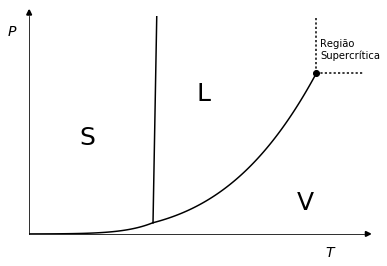

In [17]:
T_sublim = np.linspace(100,T_triple,100)
T_fus = np.linspace(T_triple, 400,100)
T_sat = np.linspace(T_triple, Tc, 100)

plt.plot(T_sublim,Psublim(T_sublim),color='k')
plt.plot(T_fus,Pfus(T_fus),color='k')
plt.plot(T_sat,Psat(T_sat),color='k')

ax = plt.gca()

xlabel = '$T$'
ylabel = '$P$'

plt.xlabel(xlabel,fontsize=14)
plt.ylabel(ylabel,rotation=0,fontsize=14)

ax.yaxis.set_label_coords(-0.05,0.9)
ax.xaxis.set_label_coords(0.9,-0.05)

arrowprops = dict(arrowstyle='<|-', facecolor='black',lw=2)
arrow_length = 10

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_yticklabels([])
ax.set_xticklabels([])

t = ax.spines['bottom'].get_transform()
xy, xycoords = [1, 0], ('axes fraction', t)
xytext, textcoords = [arrow_length, 0], ('offset points', t)

xarrow = ax.annotate('', xy, xycoords=xycoords, xytext=xytext, 
                        textcoords=textcoords, ha='left', va='center',arrowprops=arrowprops)

t = ax.spines['left'].get_transform()
xy, xycoords = [1, 0], ('axes fraction', t)
xytext, textcoords = [arrow_length, 0], ('offset points', t)

yarrow = ax.annotate('', xy[::-1], xycoords=xycoords[::-1], 
                        xytext=xytext[::-1], textcoords=textcoords[::-1], ha='center', va='center', arrowprops=arrowprops)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    labelbottom='off') # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off

plt.xlim(150,330)
plt.ylim(0,1e7)

textbox1 = 'V'
textbox2 = 'L'
textbox3 = 'S'
textbox4 = str(r'Região' + '\n' +'Supercrítica')


ax.text(0.8, 0.2, textbox1, transform=ax.transAxes, fontsize=25,
        verticalalignment='top')

ax.text(0.5, 0.7, textbox2, transform=ax.transAxes, fontsize=25,
        verticalalignment='top')

ax.text(0.15, 0.5, textbox3, transform=ax.transAxes, fontsize=25,
        verticalalignment='top')

ax.text(0.87, 0.9, textbox4, transform=ax.transAxes, fontsize=10,
        verticalalignment='top')

plt.scatter(Tc,Pc,color='k')

plt.plot([Tc,Tc],[Pc,1e9],color='k', ls=':')
plt.plot([Tc,1000],[Pc,Pc],color='k', ls=':')



plt.show()

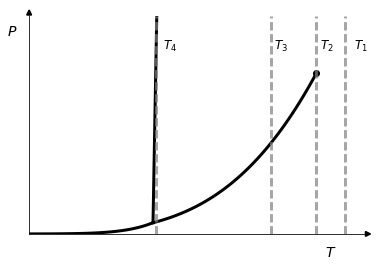

In [37]:
T_sublim = np.linspace(100,T_triple,100)
T_fus = np.linspace(T_triple, 400,100)
T_sat = np.linspace(T_triple, Tc, 100)

plt.plot(T_sublim,Psublim(T_sublim),color='k',lw=3)
plt.plot(T_fus,Pfus(T_fus),color='k',lw=3)
plt.plot(T_sat,Psat(T_sat),color='k',lw=3)

ax = plt.gca()

xlabel = '$T$'
ylabel = '$P$'

plt.xlabel(xlabel,fontsize=14)
plt.ylabel(ylabel,rotation=0,fontsize=14)

ax.yaxis.set_label_coords(-0.05,0.9)
ax.xaxis.set_label_coords(0.9,-0.05)

arrowprops = dict(arrowstyle='<|-', facecolor='black',lw=2)
arrow_length = 10

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_yticklabels([])
ax.set_xticklabels([])

t = ax.spines['bottom'].get_transform()
xy, xycoords = [1, 0], ('axes fraction', t)
xytext, textcoords = [arrow_length, 0], ('offset points', t)

xarrow = ax.annotate('', xy, xycoords=xycoords, xytext=xytext, 
                        textcoords=textcoords, ha='left', va='center',arrowprops=arrowprops)

t = ax.spines['left'].get_transform()
xy, xycoords = [1, 0], ('axes fraction', t)
xytext, textcoords = [arrow_length, 0], ('offset points', t)

yarrow = ax.annotate('', xy[::-1], xycoords=xycoords[::-1], 
                        xytext=xytext[::-1], textcoords=textcoords[::-1], ha='center', va='center', arrowprops=arrowprops)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    labelbottom='off') # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off

plt.xlim(150,330)
plt.ylim(0,1e7)

textbox1 = '$T_{1}$'
textbox2 = '$T_{2}$'
textbox3 = '$T_{3}$'
textbox4 = '$T_{4}$'

ax.text(0.97, 0.9, textbox1, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')

ax.text(0.87, 0.9, textbox2, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')

ax.text(0.73, 0.9, textbox3, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')

ax.text(0.40, 0.9, textbox4, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')


plt.scatter(Tc,Pc,color='k')

plt.plot([320,320],[0,1e7], ls='--',color='gray', alpha=0.7, lw=3)
plt.plot([Tc,Tc],[0,1e7], ls='--',color='grey', alpha=0.7, lw=3)
plt.plot([280,280],[0,1e7], ls='--',color='gray', alpha=0.7, lw=3)
plt.plot([218,218],[0,1e7], ls='--',color='grey', alpha=0.7, lw=3)

plt.show()

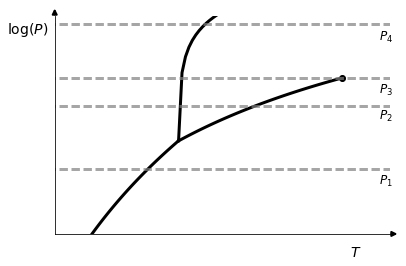

In [46]:
T_sublim = np.linspace(100,T_triple,100)
T_fus = np.linspace(T_triple, 400,100)
T_sat = np.linspace(T_triple, Tc, 100)

plt.plot(T_sublim,Psublim(T_sublim),color='k',lw=3)
plt.plot(T_fus,Pfus(T_fus),color='k',lw=3)
plt.plot(T_sat,Psat(T_sat),color='k',lw=3)

ax = plt.gca()

xlabel = '$T$'

ylabel = r'$\mathrm{log}(P)$'

plt.semilogy()

plt.xlabel(xlabel,fontsize=14)
plt.ylabel(ylabel,rotation=0,fontsize=14)

ax.yaxis.set_label_coords(-0.08,0.9)
ax.xaxis.set_label_coords(0.9,-0.05)

arrowprops = dict(arrowstyle='<|-', facecolor='black',lw=2)
arrow_length = 10

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_yticklabels([])
ax.set_xticklabels([])

t = ax.spines['bottom'].get_transform()
xy, xycoords = [1, 0], ('axes fraction', t)
xytext, textcoords = [arrow_length, 0], ('offset points', t)

xarrow = ax.annotate('', xy, xycoords=xycoords, xytext=xytext, 
                        textcoords=textcoords, ha='left', va='center',arrowprops=arrowprops)

t = ax.spines['left'].get_transform()
xy, xycoords = [1, 0], ('axes fraction', t)
xytext, textcoords = [arrow_length, 0], ('offset points', t)

yarrow = ax.annotate('', xy[::-1], xycoords=xycoords[::-1], 
                        xytext=xytext[::-1], textcoords=textcoords[::-1], ha='center', va='center', arrowprops=arrowprops)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    labelbottom='off') # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',         # ticks along the top edge are off
    labelbottom='off') # labels along the bottom edge are off

plt.xlim(150,330)
plt.ylim(1e4,1e8)

textbox1 = '$P_{1}$'
textbox2 = '$P_{2}$'
textbox3 = '$P_{3}$'
textbox4 = '$P_{4}$'

ax.text(0.97, 0.28, textbox1, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')

ax.text(0.97, 0.58, textbox2, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')

ax.text(0.97, 0.7, textbox3, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')

ax.text(0.97, 0.94, textbox4, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')


plt.scatter(Tc,Pc,color='k')

plt.plot([0,400],[Pc*0.3,Pc*0.3], ls='--',color='gray', alpha=0.7, lw=3)
plt.plot([0,400],[P_triple*0.3,P_triple*0.3], ls='--',color='grey', alpha=0.7, lw=3)
plt.plot([0,400],[Pc,Pc], ls='--',color='gray', alpha=0.7, lw=3)
plt.plot([0,400],[Pc*10,Pc*10], ls='--',color='grey', alpha=0.7, lw=3)

plt.show()